In [4]:

import tensorflow as tf
import os
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


# Check TensorFlow version
print("TensorFlow version:", tf.__version__)






TensorFlow version: 2.13.0


In [5]:
# Set manual seeds for reproducibility
manual_seed = 42
np.random.seed(manual_seed)
tf.random.set_seed(manual_seed)

In [6]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.6, min_tracking_confidence=0.6)
mp_draw = mp.solutions.drawing_utils

# Function to crop hand from an image using MediaPipe
def crop_hand_from_frame(frame, margin=0.65):
    # Convert the frame to RGB , mp uses RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process the frame and get hand landmarks
    result = hands.process(rgb_frame)
    
    if result.multi_hand_landmarks:
        for landmarks in result.multi_hand_landmarks:
            # Get bounding box for the hand (using landmarks)
            x_min = min([lm.x for lm in landmarks.landmark]) * frame.shape[1]
            x_max = max([lm.x for lm in landmarks.landmark]) * frame.shape[1]
            y_min = min([lm.y for lm in landmarks.landmark]) * frame.shape[0]
            y_max = max([lm.y for lm in landmarks.landmark]) * frame.shape[0]

            # Apply a margin to the bounding box to include more area around the hand
            width = x_max - x_min
            height = y_max - y_min

            # Increase the bounding box by the margin (adjust by a factor of the width/height)
            x_min = int(max(x_min - margin * width, 0))
            x_max = int(min(x_max + margin * width, frame.shape[1]))
            y_min = int(max(y_min - margin * height, 0))
            y_max = int(min(y_max + margin * height, frame.shape[0]))

            # Crop the hand region from the frame
            hand_crop = frame[y_min:y_max, x_min:x_max]

            # Ensure the crop is valid
            if hand_crop.shape[0] > 0 and hand_crop.shape[1] > 0:
                return hand_crop
    
    # Return None if no hand is detected
    return None


In [7]:

#  resize image
IMG_SIZE = 128  

# path to dataset
data_path = "rawData/WebcamSerie"

# Initialize lists for images and labels
images = []
labels = []

# Counter for no hands detected
undetected_hands_count = 0

# Define label map 
label_map = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8,
             'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16,
             's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}

# Load images from the dataset
for filename in os.listdir(data_path):
    if filename.endswith(".png"):  # Filter for PNG files
        img_path = os.path.join(data_path, filename)

        # Open the image and process
        try:
            img = Image.open(img_path)
            img = img.convert("RGB")  # Ensure it's in RGB format
            img = np.array(img)
            
            # Crop the hand from the image using the MediaPipe function
            cropped_hand = crop_hand_from_frame(img)

            if cropped_hand is not None:
                # Resize the cropped hand to IMG_SIZE
                cropped_hand = cv2.resize(cropped_hand, (IMG_SIZE, IMG_SIZE))

                # Normalize image
                cropped_hand = cropped_hand.astype("float32") / 255.0
                images.append(cropped_hand)

                # Extract the label from the filename
                label = filename[0].lower()
                label_num = label_map.get(label)
                if label_num is not None:
                    labels.append(label_num)
                else:
                    print(f"Invalid label: {label} in filename: {filename}")
            else:
                print(f"No hand detected in {filename}")
                undetected_hands_count += 1  # Increment counter
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

# Convert images and labels into numpy arrays
images = np.array(images)
labels = np.array(labels)

# Check if data was loaded correctly
if images.size == 0 or labels.size == 0:
    raise ValueError("No images or labels found. Check the folder path and filenames.")

# Convert labels to categorical format (one-hot encoding)
labels = to_categorical(labels)

# Print the number of images where no hand was detected
print(f"Number of images where no hand was detected: {undetected_hands_count}")


No hand detected in h55.png
No hand detected in m25.png
No hand detected in m26.png
No hand detected in m27.png
No hand detected in m28.png
No hand detected in m29.png
No hand detected in m3.png
No hand detected in m70.png
No hand detected in m71.png
No hand detected in m72.png
No hand detected in m73.png
No hand detected in m74.png
No hand detected in m75.png
No hand detected in m76.png
No hand detected in m77.png
No hand detected in m78.png
No hand detected in m79.png
No hand detected in m8.png
No hand detected in m80.png
No hand detected in m81.png
No hand detected in m82.png
No hand detected in m83.png
No hand detected in m84.png
No hand detected in m85.png
No hand detected in m86.png
No hand detected in m87.png
No hand detected in m88.png
No hand detected in m89.png
No hand detected in m9.png
No hand detected in m90.png
No hand detected in m91.png
No hand detected in m92.png
No hand detected in m93.png
No hand detected in m94.png
No hand detected in m95.png
No hand detected in m96

In [8]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Check the shape of the data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define data augmentation layer with a fixed seed
data_augmentation = Sequential([
    RandomRotation(0.1, seed=manual_seed),       # random rotation 10%
    RandomZoom(0.1, seed=manual_seed),           # Random zoom 10%
])

# Model definition 
model = Sequential()

model.add(data_augmentation)  # Data augmentation applied

# Convolutional layers (3 layers)
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))



# Flatten the output to feed into dense layers
model.add(Flatten())

# Fully connected layer with 64 units
model.add(Dense(units=64, activation='relu'))

# Dropout layer
model.add(Dropout(0.3))

# Output layer for 24 classes
model.add(Dense(units=24, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)



Training data shape: (1778, 128, 128, 3)
Testing data shape: (445, 128, 128, 3)


In [9]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[early_stopping])
#Training set size: 1,601 samples
#Validation set size: 177 samples

# Save the model
model.save('model/hand_gesture_CNN_model3.h5')  # save model

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/100
50/50 [==============================] - 18s 326ms/step - loss: 3.1808 - accuracy: 0.0450 - val_loss: 3.1692 - val_accuracy: 0.0730
Epoch 2/100
50/50 [==============================] - 15s 305ms/step - loss: 3.1628 - accuracy: 0.0487 - val_loss: 3.1687 - val_accuracy: 0.0787
Epoch 3/100
50/50 [==============================] - 15s 295ms/step - loss: 3.1601 - accuracy: 0.0469 - val_loss: 3.1513 - val_accuracy: 0.0506
Epoch 4/100
50/50 [==============================] - 15s 290ms/step - loss: 3.1243 - accuracy: 0.0750 - val_loss: 3.0190 - val_accuracy: 0.0674
Epoch 5/100
50/50 [==============================] - 15s 295ms/step - loss: 2.9626 - accuracy: 0.1194 - val_loss: 2.6243 - val_accuracy: 0.2528
Epoch 6/100
50/50 [==============================] - 14s 288ms/step - loss: 2.6593 - accuracy: 0.2113 - val_loss: 2.0959 - val_accuracy: 0.3764
Epoch 7/100
50/50 [==============================] - 14s 289ms/step - loss: 2.3636 - accuracy: 0.2806 - val_loss: 1.7779 - val_accuracy:

c:\Users\haziq\anac3\anaconda3\envs\test\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 59ms/step - loss: 0.2981 - accuracy: 0.8899
Test Loss: 0.2980839014053345
Test Accuracy: 0.8898876309394836


1/1 [==============================] - 0s 182ms/step


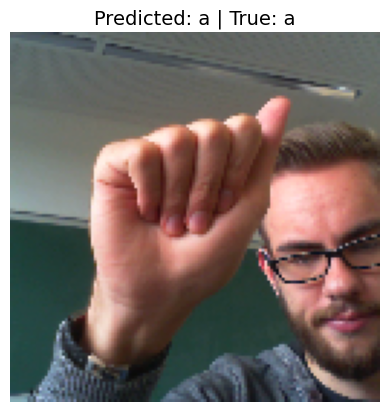

1/1 [==============================] - 0s 28ms/step


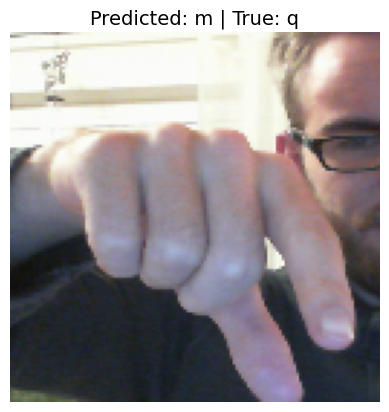

1/1 [==============================] - 0s 32ms/step


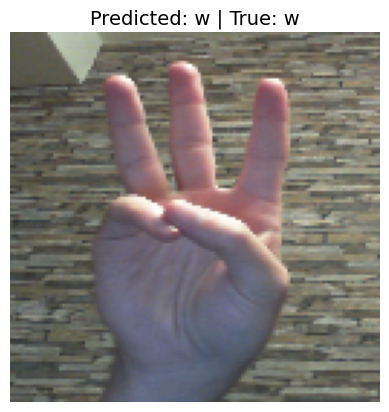

1/1 [==============================] - 0s 36ms/step


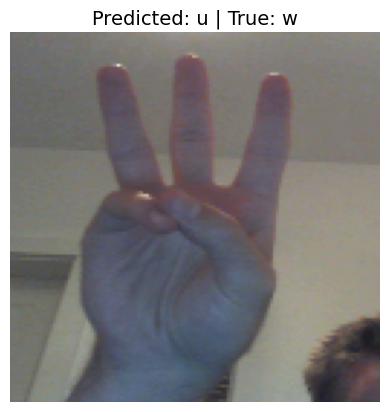

1/1 [==============================] - 0s 28ms/step


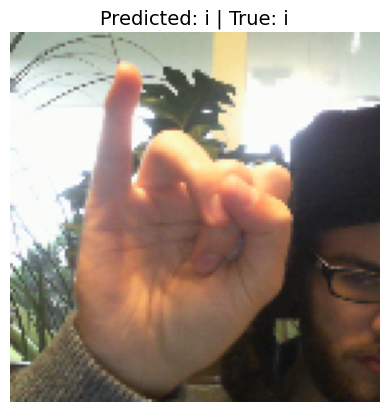

1/1 [==============================] - 0s 28ms/step


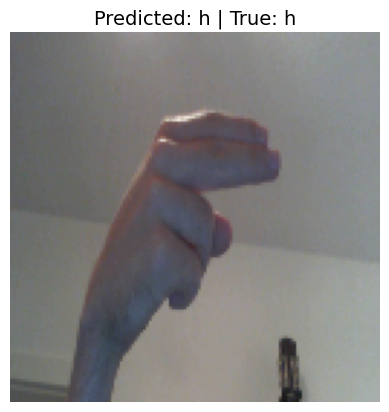

1/1 [==============================] - 0s 36ms/step


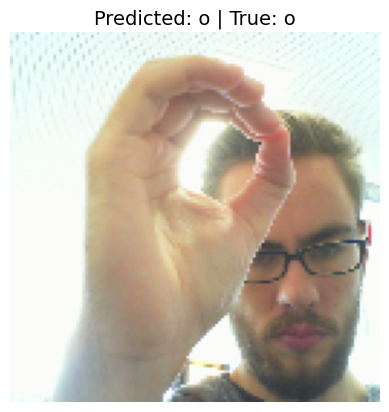

1/1 [==============================] - 0s 35ms/step


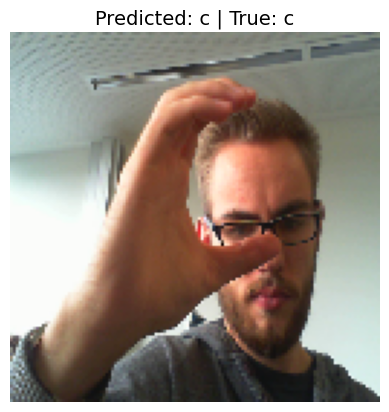

1/1 [==============================] - 0s 32ms/step


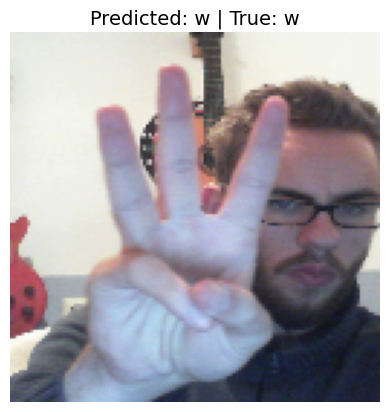

1/1 [==============================] - 0s 32ms/step


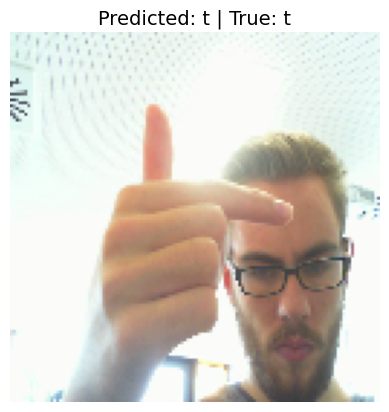

1/1 [==============================] - 0s 36ms/step


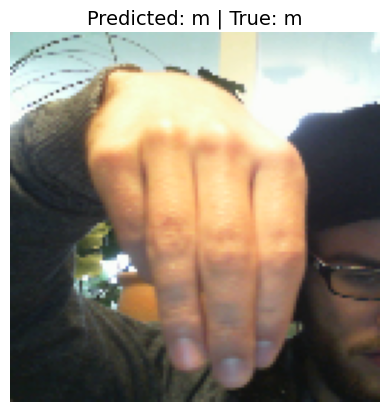

1/1 [==============================] - 0s 29ms/step


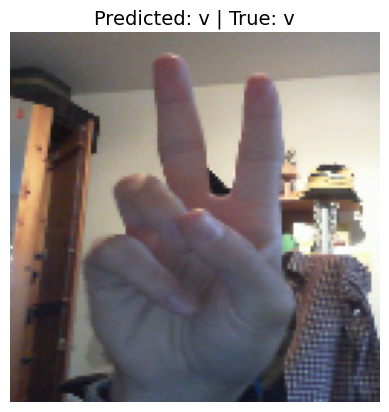

1/1 [==============================] - 0s 44ms/step


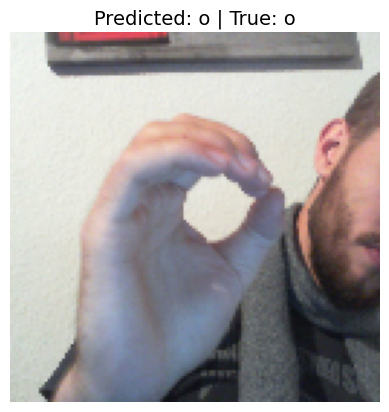

1/1 [==============================] - 0s 43ms/step


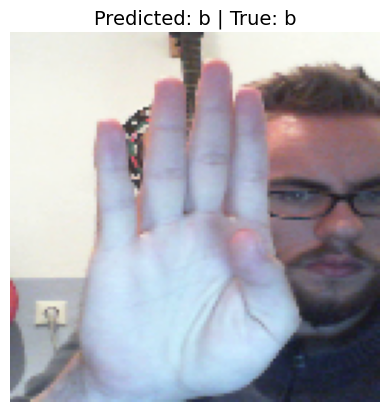

1/1 [==============================] - 0s 33ms/step


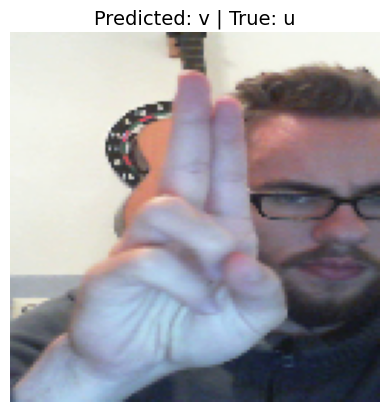

1/1 [==============================] - 0s 44ms/step


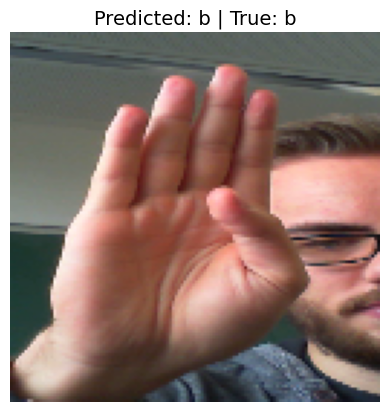

1/1 [==============================] - 0s 28ms/step


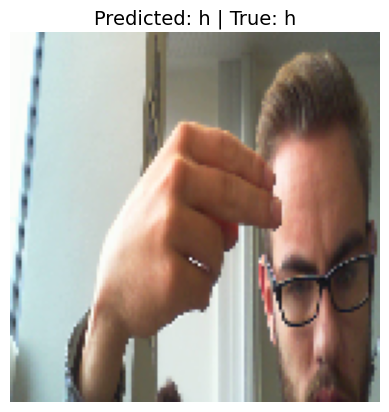

1/1 [==============================] - 0s 34ms/step


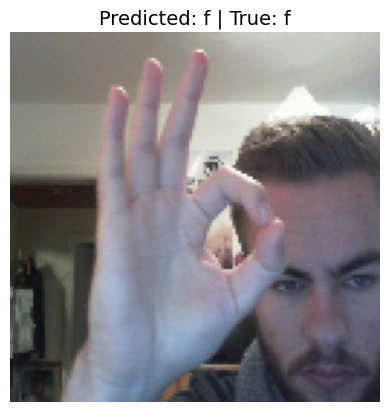

1/1 [==============================] - 0s 57ms/step


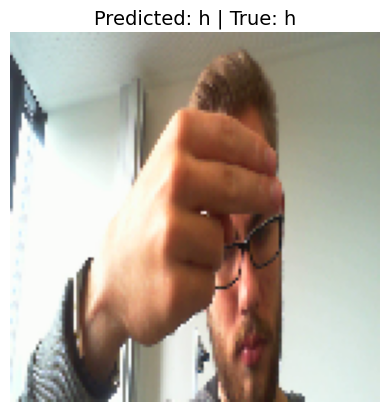

1/1 [==============================] - 0s 32ms/step


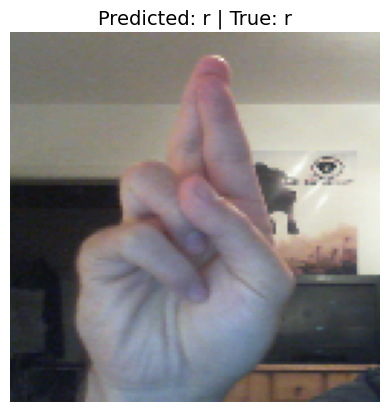

1/1 [==============================] - 0s 32ms/step


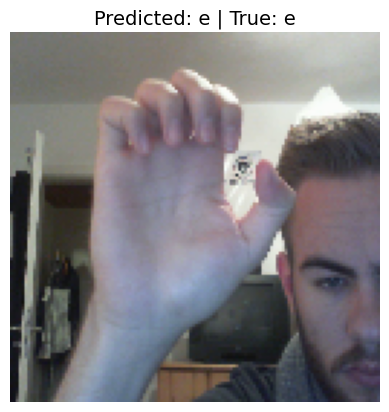

1/1 [==============================] - 0s 48ms/step


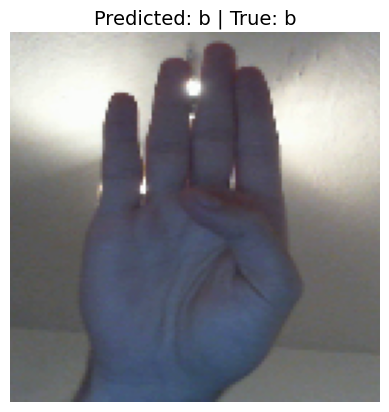

1/1 [==============================] - 0s 36ms/step


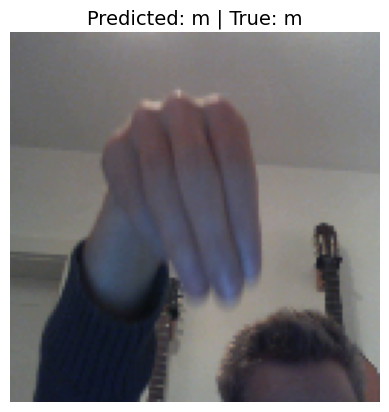

1/1 [==============================] - 0s 32ms/step


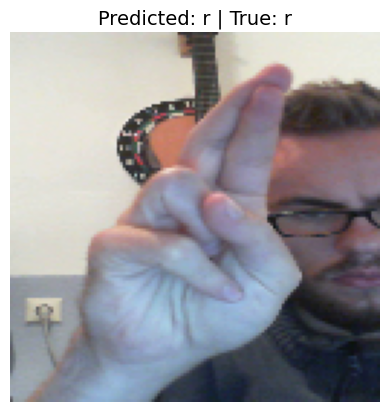

1/1 [==============================] - 0s 28ms/step


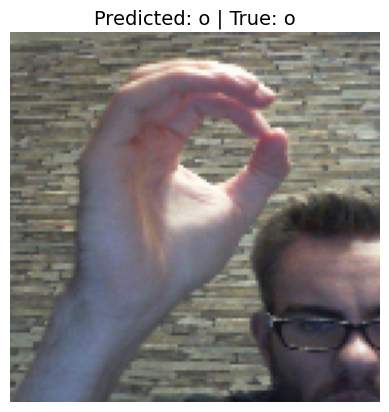

1/1 [==============================] - 0s 25ms/step


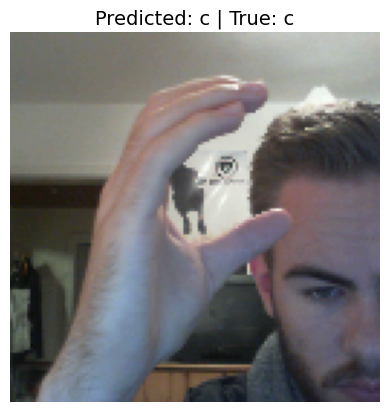

1/1 [==============================] - 0s 28ms/step


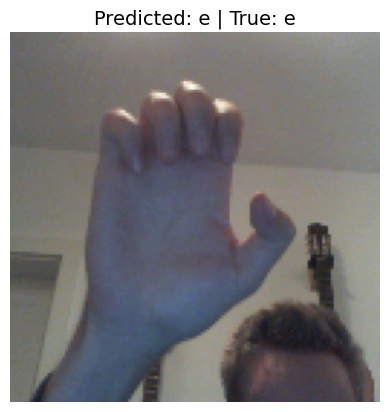

1/1 [==============================] - 0s 28ms/step


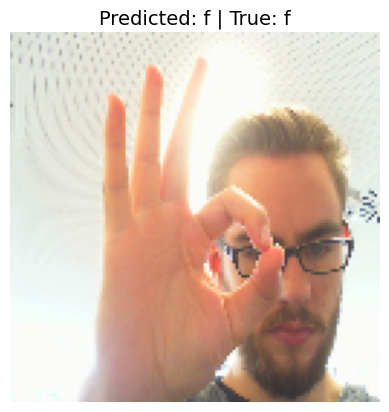

1/1 [==============================] - 0s 28ms/step


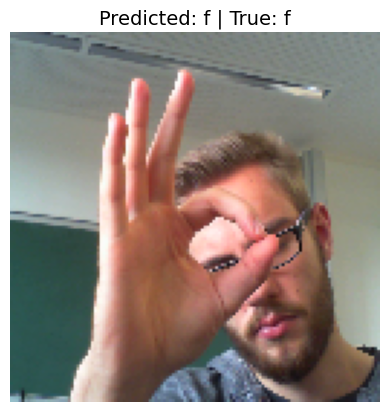

1/1 [==============================] - 0s 28ms/step


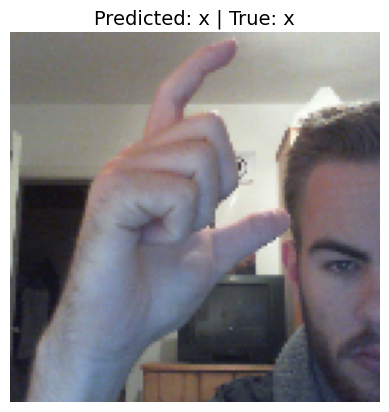

1/1 [==============================] - 0s 28ms/step


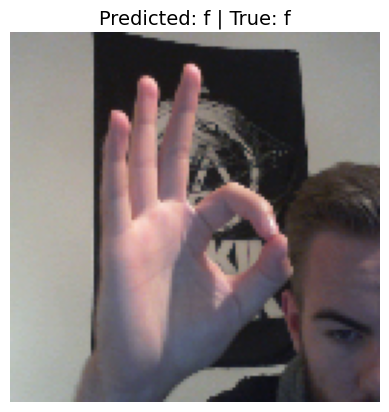

1/1 [==============================] - 0s 28ms/step


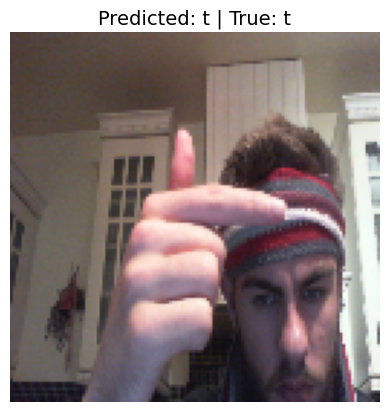

1/1 [==============================] - 0s 25ms/step


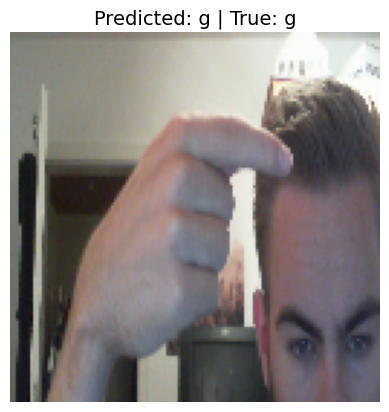

1/1 [==============================] - 0s 28ms/step


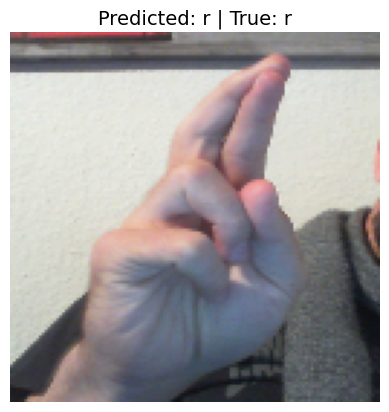

1/1 [==============================] - 0s 28ms/step


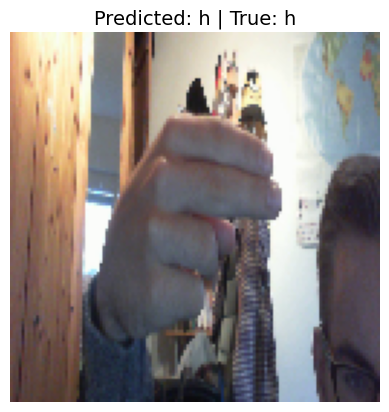

1/1 [==============================] - 0s 24ms/step


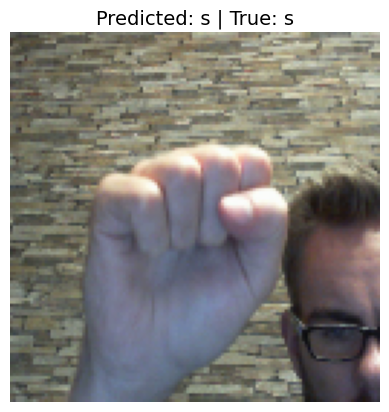

1/1 [==============================] - 0s 32ms/step


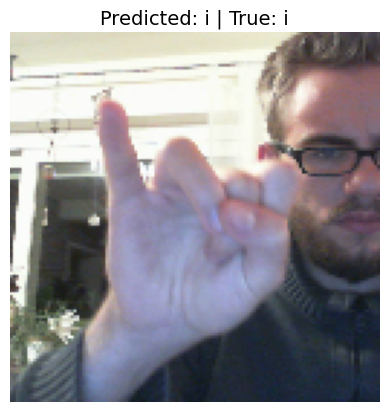

1/1 [==============================] - 0s 28ms/step


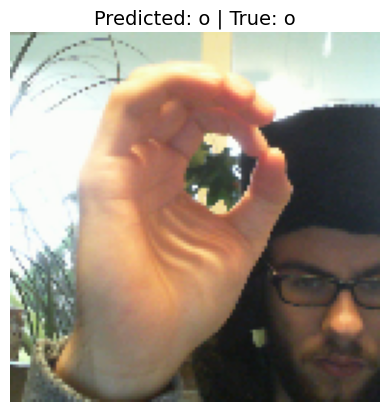

1/1 [==============================] - 0s 32ms/step


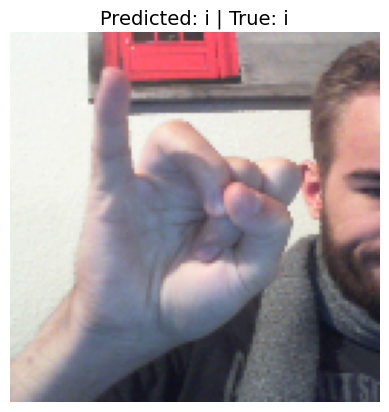

1/1 [==============================] - 0s 32ms/step


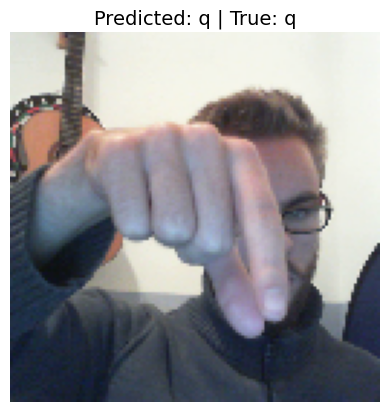

In [10]:

# Load the trained model
model = load_model('model/hand_gesture_CNN_model3.h5')  # load model

# Number of test images to display
num_images = 40

# Prepare the test images for display
test_images = X_test[:num_images]
test_labels = y_test[:num_images]

# Convert the test images back to a format suitable for display since it was normalized
test_images_display = np.clip(test_images * 255, 0, 255).astype(np.uint8)

# Create a reverse label map for easy lookup 
reverse_label_map = {v: k for k, v in label_map.items()}

# Loop through the test images, predict their labels, and display them one by one
for i in range(num_images):
    # Predict the label for the test image
    image_input = np.expand_dims(test_images[i], axis=0)  # Add batch dimension
    predictions = model.predict(image_input)
    predicted_label_index = np.argmax(predictions)
    predicted_label = reverse_label_map[predicted_label_index]

    # True label
    true_label_index = np.argmax(test_labels[i])
    true_label = reverse_label_map[true_label_index]

    # Plot the test image
    plt.imshow(test_images_display[i])
    plt.axis('off')  # Turn off axis 

    # title
    plt.title(f"Predicted: {predicted_label} | True: {true_label}", fontsize=14)
    
    # Show the plot
    plt.show()


# Task: Predict and Display the Top 3 Predictions for the First Test Image

In this task, you will:
1. Prepare the first image from the test dataset for prediction and display.
2. Use the trained model to predict the class probabilities for the image.
3. Identify the top 3 predictions based on the confidence scores.
4. Display the first test image along with the top 3 predictions and their confidence levels.

Prediction: a | Confidence: 80.90%
Prediction: g | Confidence: 14.73%
Prediction: h | Confidence: 3.22%


(-0.5, 127.5, 127.5, -0.5)

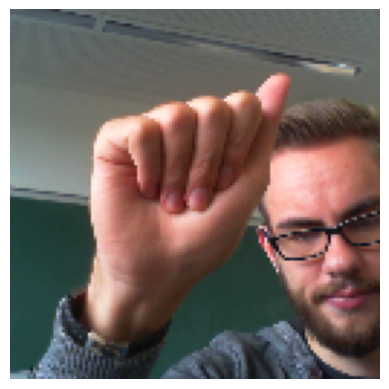

In [26]:
# Prepare the first test image for display
test_image = X_test[0]  # First image in the test set
test_image_display = np.clip(test_image * 255, 0, 255).astype(np.uint8)  # Convert normalized image

# Make prediction for the first image
image_input = np.expand_dims(test_image, axis=0)  # Add batch dimension
predictions = model.predict(image_input, verbose=0)

# Get the prediction probabilities for the classes
class_probabilities = predictions[0]  

# Sort the prediction probabilities 
sorted_indices = np.argsort(class_probabilities)[::-1][:3]  # top 3 indices

# Get the top 3 confidence scores using the sorted indices
top_3_confidences = class_probabilities[sorted_indices]  

# labels of top 3 indices
top_3_labels = [reverse_label_map[index] for index in sorted_indices]  

# Display the top 3 predictions with their confidence scores
for label, confidence in zip(top_3_labels, top_3_confidences):
    print(f"Prediction: {label} | Confidence: {confidence*100:.2f}%")

# Display the first test image
plt.imshow(test_image_display)
plt.axis('off')  # Turn off axis


In [22]:
import cv2
import numpy as np
import os

# Initialize camera
camera = cv2.VideoCapture(0)  # 0 for the default camera
if not camera.isOpened():
    print("Error: Could not open camera")
    exit()

# Ensure the directory exists for saving images
if not os.path.exists("saved_images"):
    os.makedirs("saved_images")

# Start the camera feed loop
while True:
    ret, frame = camera.read()  # Capture frame 
    if not ret:
        print("Failed to capture frame")
        break

    # Preprocess the frame and crop the hand
    hand_crop = crop_hand_from_frame(frame)

    if hand_crop is not None:
        try:
            # Resize the hand crop to fit the model input
            hand_crop = cv2.resize(hand_crop, (IMG_SIZE, IMG_SIZE))
            hand_crop = hand_crop.astype('float32') / 255.0

            # Make prediction 
            processed_frame = np.expand_dims(hand_crop, axis=0)
            predictions = model.predict(processed_frame, verbose=0)  
            predicted_label = np.argmax(predictions)
            confidence = predictions[0][predicted_label]  # Get the confidence of the prediction

            # If confidence is above 60%, display the prediction
            if confidence > 0.6:
                # Map predicted label index to character
                predicted_class = list(label_map.keys())[predicted_label]

                # Display the prediction on the frame
                cv2.putText(frame, f"Prediction: {predicted_class} ({confidence*100:.2f}%)", 
                            (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            else:
                # If confidence is less than 60%, display no prediction
                cv2.putText(frame, "Prediction: Uncertain", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                            (0, 0, 255), 2, cv2.LINE_AA)

        except Exception as e:
            print(f"Error during prediction: {e}")

    # Show the frame with prediction
    cv2.imshow("Camera Feed", frame)

    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Quit if 'q' is pressed
        break
    elif key == 32:  # Spacebar is pressed
        # If confidence is above 60%,
        if confidence > 0.6:
            # Save the image with predicted letter as filename
            filename = f"saved_images/{predicted_class}.png"
            cv2.imwrite(filename, frame) 
            #print(f"Image saved as {filename}")

            # Display the predicted letter on the screen
            cv2.putText(frame, f"Predicted Letter: {predicted_class}", 
                        (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
            print(f"Predicted Letter: {predicted_class}")
        else:
            # If the confidence is low, display a message
            cv2.putText(frame, "Prediction confidence too low", 
                        (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            print("Prediction confidence too low.")

        # Show the frame with the updated text
        cv2.imshow("Camera Feed", frame)

# Release the camera and close windows
camera.release()
cv2.destroyAllWindows()


Predicted Letter: h
Predicted Letter: a
Predicted Letter: i
Predicted Letter: q
